In [1]:
"""Sandbox module."""
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import skfda
from misc import (
    kernel_estimator,
    cdf_estimator,
    norm_density,
    norm_cdf,
    riemann_sum,
    riemann_sum_arrays,
    l2_norm,
)
from scipy.stats import norm
from skfda.preprocessing.dim_reduction import FPCA

%matplotlib inline

$\int_0^1 f(t)dt$  wird dann durch die Riemann Summe $1/m \sum_{j=1}^m f(s_j)$ ersetzt ($s_j$  - Gridpunkte, $m$ -  Anzahl der Gridpunkte).

# Nonparametric Statistics

## Kernel density estimation

### To implement: Adjusted estimator from Müller and Petersen 2016, and compact support

### Fix parameters and generate sample

In [2]:
n = 100
n_grid = 200
grid_ending = 30
mu = 0
sigma = 10

sample = np.random.default_rng(seed=28071995).normal(loc=mu, scale=sigma, size=n)
grid = np.linspace(start=-grid_ending, stop=grid_ending, num=n_grid)
# Rule-of-Thumb bandwidth (Li and Racine 2007, p. 66)
bandwidth = np.std(sample) * (n ** (-0.2))  # should implement optimal bandwidth

In [3]:
kernel_estimator_given_sample = partial(kernel_estimator, sample=sample)

### Generate fitted values

In [4]:
values_epa = kernel_estimator_given_sample(
    x=grid,
    h=bandwidth,
    kernel_type="epanechnikov",
)
values_uni = kernel_estimator_given_sample(x=grid, h=bandwidth, kernel_type="uniform")
values_tri = kernel_estimator_given_sample(
    x=grid,
    h=bandwidth,
    kernel_type="triangular",
)
values_cdf = cdf_estimator(x=grid, f=kernel_estimator, h=bandwidth, sample=sample)

### Plots

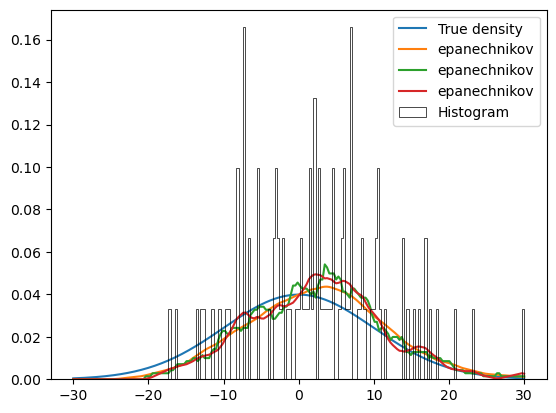

In [5]:
fig, ax = plt.subplots()
ax.plot(grid, norm.pdf(grid, loc=mu, scale=sigma), label="True density")
ax.plot(grid, values_epa, label="epanechnikov")
ax.plot(grid, values_uni, label="epanechnikov")
ax.plot(grid, values_tri, label="epanechnikov")
# plot histogram for comparison
ax.hist(
    sample,
    bins=grid,
    density=True,
    histtype="step",
    edgecolor="black",
    linewidth=0.5,
    label="Histogram",
)
plt.legend()
plt.show()

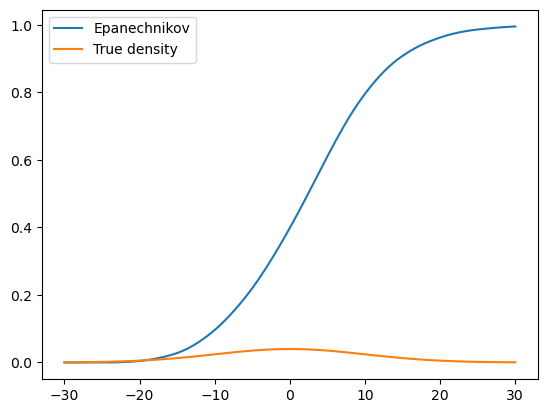

In [6]:
fig, ax = plt.subplots()
ax.plot(grid, values_cdf, label="Epanechnikov")
ax.plot(grid, norm.pdf(grid, loc=mu, scale=sigma), label="True density")
plt.legend()
plt.show()

## Kernel Regression

Context: we want to investigate the nonparametric regression relation $y_i = m(x_i) +
\epsilon_i$, where $y_i$ is a dependent variable, $x_i$ an explanatory variable, and
$\epsilon_i$ an iid error term, for observations $i = 1, ..., n$.

### Sample generation

In [ ]:
def m(x):
    """True function."""
    return 3 * np.sin(x) + 2 * x

In [ ]:
epsilon = np.random.default_rng(seed=28071995).normal(0, sigma / 2, size=n)
y = m(sample) + epsilon

In [ ]:
def nw_estimator(x, y, h, sample, kernel_type):
    """Nadaraya - Watson / Local constant estimator."""
    k = np.vectorize(kernels[kernel_type])
    k0 = k((x - sample) / h)
    numerator = np.sum(k0 * y)
    denominator = np.sum(k0)
    return numerator / denominator

In [ ]:
def ll_estimator(x, y, h, sample, kernel_type):
    """Local linear estimator. See Li & Racine, p. 81."""
    k = np.vectorize(kernels[kernel_type])
    k_0 = k((x - sample) / h)
    s_2 = np.sum(k_0 * (sample - x) ** 2)
    s_1 = np.sum(k_0 * (sample - x))
    w = k_0 * (s_2 - s_1 * (sample - x))
    numerator = np.sum(w * y)
    denominator = np.sum(w)
    return numerator / denominator

In [ ]:
def ll_estimator2(x, y, h, sample, kernel_type):
    """Local linear estimator. See Li & Racine, p. 81."""
    k = np.vectorize(kernels[kernel_type])
    w = np.diag(k((sample - x) / h))
    z = np.array((np.ones(len(sample)), sample - x))
    return np.linalg.inv(z.dot(w).dot(z.transpose())).dot(z).dot(w).dot(y)

In [ ]:
def loocv_error(h, y, sample, kernel_type):
    """Compute the LOOCV error for a given bandwidth."""
    error_nw = 0
    error_ll = 0
    estimator_nw = partial(nw_estimator, h=h, sample=sample, kernel_type=kernel_type)
    estimator_ll = partial(ll_estimator, h=h, sample=sample, kernel_type=kernel_type)

    # For each observation
    for i in range(len(sample)):
        # Create a new sample excluding the current observation
        sample_loo = np.delete(sample, i)
        y_loo = np.delete(y, i)

        # Update the sample and y in the estimator
        estimator_nw.keywords["sample"] = sample_loo
        estimator_nw.keywords["y"] = y_loo
        estimator_ll.keywords["sample"] = sample_loo
        estimator_ll.keywords["y"] = y_loo

        # Compute the prediction for the left-out observation
        prediction_nw = estimator_nw(x=sample[i])
        prediction_ll = estimator_ll(x=sample[i])

        # Add the squared error to the total error
        if not np.isnan(prediction_nw):
            error_nw += (y[i] - prediction_nw) ** 2
        if not np.isnan(prediction_ll):
            error_ll += (y[i] - prediction_ll) ** 2

    # Return the average error
    return error_nw / len(sample), error_ll / len(sample)


# List of bandwidths to consider
h_values = np.linspace(0.2, 2, 100)

# Compute the LOOCV error for each bandwidth
loocv_part = partial(loocv_error, sample=sample, y=y, kernel_type="epanechnikov")
loocv_vec = np.vectorize(loocv_part)
errors = loocv_vec(h_values)

# Choose the bandwidth with the smallest error
loocv_h_nw, loocv_h_ll = h_values[np.argmin(errors, axis=1)]
f"Optimal bandwidth: {loocv_h_nw, loocv_h_ll}"

In [ ]:
temp1 = partial(
    nw_estimator,
    y=y,
    h=loocv_h_nw,
    sample=sample,
    kernel_type="epanechnikov",
)
temp2 = np.vectorize(temp1)
temp3 = partial(
    ll_estimator,
    y=y,
    h=loocv_h_ll,
    sample=sample,
    kernel_type="epanechnikov",
)
temp4 = np.vectorize(temp3)

In [ ]:
fig, ax = plt.subplots()
ax.plot(grid, m(grid), label="True relation")
ax.plot(grid, temp2(x=grid), label="Nadaraya-Watson estimator")
ax.plot(grid, temp4(x=grid), label="Local linear estimator")
plt.legend()
plt.show()

Apparently the Leave-One-Out Cross Validation algorithm gets stuck in a local optimum with very small bandwidths, at least for the Nadaraya-Watson estimator. I don't understand why, maybe because it can get perfect in sample fit if the observations are not so dense?

# Functional Data Analysis

Ideas for simulation
- Uni- vs. Multivariate case
- Simulate different normal distributions
- Vary parameters of (generalized) Beta distribution, so principal components can be interpreted as varying parameters

$X(t) = \sum_{k=1}^n η_k φ_k(t)$


## Transformation Method Paper (Petersen & Müller 2016)

In [7]:
# Equispaced grid on [0, 1]
n = 200
gridnum = 100
grid_densities_univ = np.linspace(start=-5, stop=5, num=gridnum)
grid_quantiles_univ = np.linspace(start=0, stop=1, num=gridnum)
# Draw different sigmas
grid_densities = np.linspace(start=-np.ones(n), stop=np.ones(n), num=gridnum)
grid_quantiles = np.linspace(
    start=np.ones(n) * 0.01,
    stop=np.ones(n) * 0.99,
    num=gridnum,
)
log_sigmas = np.random.default_rng(seed=28071995).uniform(-1.5, 1.5, n)
mus = np.zeros(n)
sigmas = np.exp(log_sigmas)
densities_discretized = norm_density(grid_densities, mus, sigmas).transpose()
quantiles_discretized = norm.ppf(grid_quantiles, mus, sigmas).transpose()
quantile_densities_discretized = np.reciprocal(
    norm_density(norm.ppf(grid_quantiles, mus, sigmas), mus, sigmas),
).transpose()

In [54]:
cdfs_discretized = np.cumsum(densities_discretized, axis=1) * np.diff(grid_densities_univ)[0]
cdfs_discretized[0][-1]

4.861066856454568

In [56]:
np.cumsum(densities_discretized, axis=1).shape

((200, 100), (200, 100))

In [ ]:
# Do FPCA via package
fpca_discretized = FPCA(n_components=2)
fd = skfda.FDataGrid(
    data_matrix=densities_discretized,
    grid_points=grid_densities_univ,
    dataset_name="Density Samples",
    argument_names=("x-Value",),
    coordinate_names=("Density",),
)
fpca_discretized.fit(fd)
fpca_discretized.components_.plot()

In [ ]:
# Sample densities
partial_vectorized = np.vectorize(partial)
densities = partial_vectorized(norm_density, mu=mus, sigma=sigmas)

In [ ]:
# Manual computation of FPCs, but bad! Better: replace it with np.mean of
# densities_discretized
# Sample Mean:
def sample_mean(x: float, sample_funcs: np.ndarray) -> float:
    """Compute mean function."""
    sum_of_funcs = 0
    for f in sample_funcs:
        sum_of_funcs += f(x)
    return 1 / len(sample_funcs) * sum_of_funcs

In [ ]:
def sample_cov_func(x: float, y: float, mean_func: callable, sample_funcs: np.ndarray):
    """Compute covariance function."""
    x = np.array(x)
    y = np.array(y)
    mean_x = mean_func(x, sample_funcs)
    mean_y = mean_func(y, sample_funcs)
    sum_cross_products = 0
    sum_x_evals = 0
    sum_y_evals = 0
    for f in sample_funcs:
        sum_cross_products += f(x) * f(y)
        sum_x_evals += f(x)
        sum_y_evals += f(y)
    return mean_x * mean_y + 1 / len(sample_funcs) * (
        sum_cross_products - mean_x * sum_y_evals - mean_y * sum_x_evals
    )

In [ ]:
def sample_cov_func2(x: float, y: float, mean_func: callable, sample_funcs: np.ndarray):
    """Compute covariance function."""
    x = np.array(x)
    y = np.array(y)
    mean_x = mean_func(x, sample_funcs)
    mean_y = mean_func(y, sample_funcs)
    sum_products = 0
    for f in sample_funcs:
        sum_products += (f(x) - mean_x) * (f(y) - mean_y)
    return 1 / len(sample_funcs) * sum_products

In [ ]:
# See whether they agree on the the result, they should
sample_cov_func(0, 0.5, sample_mean, densities), sample_cov_func2(
    0,
    0.5,
    sample_mean,
    densities,
)

In [ ]:
%%timeit
approx_cov_func = np.zeros((gridnum, gridnum))
for i in range(gridnum):
    approx_cov_func[i] = sample_cov_func(
        grid_densities_univ,
        grid_densities_univ[i],
        sample_mean,
        densities,
    )

In [ ]:
%%timeit
approx_cov_func2 = np.zeros((gridnum, gridnum))
for i in range(gridnum):
    approx_cov_func2[i] = sample_cov_func2(
        grid_densities_univ,
        grid_densities_univ[i],
        sample_mean,
        densities,
    )

In [ ]:
%%timeit
approx_cov_np = np.cov(densities_discretized.transpose())

Numpy command obviously much faster, so won't use my own functions.